In [418]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des fichiers

In [419]:
# List files available
print(os.listdir("data"))

['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'application_train_split.csv', 'POS_CASH_balance.csv', 'application_test_split.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'train2.csv', 'bureau.csv', '.ipynb_checkpoints', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


# Nettoyage / Feature engineering / Séparation

In [420]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import os
import warnings

warnings.filterwarnings("ignore")


def split_and_save_data(input_file):
    """Séparer les données en ensembles de formation et de test et les enregistrer en fichiers CSV."""
    # Charger les données
    app_train = pd.read_csv(input_file)
    
    # Séparer les données en ensembles de formation et de test
    train_data, test_data = train_test_split(app_train, test_size=0.3)
    
    # Exporter les ensembles train et test en fichiers CSV
    train_data.to_csv('data/application_train_split.csv', index=False)
    test_data.to_csv('data/application_test_split.csv', index=False)
    
    print('Les fichiers ont été exportés avec succès.')

def feature_engineering(train_file, test_file):
    """Créer de nouvelles fonctionnalités à partir des données existantes et enregistrer les modifications dans les fichiers CSV."""
    # Chargement des données
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    
    # Création des nouvelles colonnes
    train['AMT_ANNUITY/INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    test['AMT_ANNUITY/INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    
    train['credit_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
    test['credit_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    
    train['credit_goods_price_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
    test['credit_goods_price_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    
    train['credit_downpayment'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
    test['credit_downpayment'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
    
    train['AGE_INT'] = (train['DAYS_BIRTH'] / -365).astype(int)
    test['AGE_INT'] = (test['DAYS_BIRTH'] / -365).astype(int)
    
    # Enregistrement des modifications dans les fichiers CSV
    train.to_csv(train_file, index=False)
    test.to_csv(test_file, index=False)
    
    # Impression des premières lignes pour vérifier les modifications
    print('Train data head:\n', train.head(3))
    print('Test data head:\n', test.head(3))
    
    return train, test

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    if not os.path.isfile(train_file):
        raise FileNotFoundError(f"Le fichier {train_file} est introuvable.")
    if not os.path.isfile(test_file):
        raise FileNotFoundError(f"Le fichier {test_file} est introuvable.")
    
    print("Début du nettoyage des données...")

    # Charger les données
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Encodage des variables catégorielles
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Préparer les ensembles d'entraînement et de test
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les caractéristiques
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']

# Appel de la fonction pour séparer et sauvegarder les données
split_and_save_data('data/application_train.csv')

# Appel de la fonction pour le feature engineering
train_file = 'data/application_train_split.csv'
test_file = 'data/application_test_split.csv'
feature_engineering(train_file, test_file)

# Appel de la fonction pour le nettoyage des données
train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)


Les fichiers ont été exportés avec succès.
Train data head:
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      289190       0         Cash loans           M            N   
1      373175       0         Cash loans           F            Y   
2      197329       0    Revolving loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          112500.0    263686.5      25816.5   
1               N             0          135000.0    163008.0      16006.5   
2               Y             0           76500.0    180000.0       9000.0   

   ...  AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK  \
0  ...                        0.0                        0.0   
1  ...                        NaN                        NaN   
2  ...                        NaN                        NaN   

  AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT  \
0                       0.0        

In [421]:
# Testing data features
app_test = pd.read_csv('data/application_test_split.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (71013, 127)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY/INCOME,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,310537,0,Cash loans,M,Y,N,0,270000.0,675000.0,21775.5,...,0.0,0.0,0.0,0.0,0.0,0.080650,30.998140,1.0000,0.0,27
1,215200,0,Cash loans,F,N,Y,1,103500.0,431280.0,22149.0,...,0.0,0.0,1.0,0.0,3.0,0.214000,19.471759,1.1980,-71280.0,44
2,272060,0,Cash loans,F,N,N,2,292500.0,1350000.0,39474.0,...,0.0,0.0,0.0,0.0,1.0,0.134954,34.199726,1.0000,0.0,33
3,259655,0,Cash loans,M,Y,N,0,202500.0,474048.0,28642.5,...,0.0,0.0,0.0,0.0,3.0,0.141444,16.550511,1.3168,-114048.0,27
4,230888,0,Cash loans,M,N,N,0,225000.0,675000.0,64089.0,...,NaN,NaN,NaN,NaN,NaN,0.284840,10.532229,1.0000,0.0,37


# Analyse exploratoire

## Données

### Données manquantes

In [423]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [424]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 244 columns.
There are 66 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,165543,69.9
COMMONAREA_AVG,165543,69.9
COMMONAREA_MODE,165543,69.9
NONLIVINGAPARTMENTS_AVG,164415,69.5
NONLIVINGAPARTMENTS_MODE,164415,69.5
NONLIVINGAPARTMENTS_MEDI,164415,69.5
LIVINGAPARTMENTS_AVG,161920,68.4
LIVINGAPARTMENTS_MEDI,161920,68.4
LIVINGAPARTMENTS_MODE,161920,68.4
FLOORSMIN_MODE,160697,67.9


In [426]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [428]:
# Encodage one-hot des variables catégorielles
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Dimensions des caractéristiques d\'entraînement : ', app_train.shape)
print('Dimensions des caractéristiques de test : ', app_test.shape)

Dimensions des caractéristiques d'entraînement :  (236709, 244)
Dimensions des caractéristiques de test :  (71013, 249)


In [429]:
# Extraire les étiquettes de la colonne TARGET
train_labels = app_train['TARGET']

# Aligner les données d'entraînement et de test, garder uniquement les colonnes présentes dans les deux dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Réintégrer la cible
app_train['TARGET'] = train_labels

print('Dimensions des caractéristiques d\'entraînement : ', app_train.shape)
print('Dimensions des caractéristiques de test : ', app_test.shape)


Dimensions des caractéristiques d'entraînement :  (236709, 242)
Dimensions des caractéristiques de test :  (71013, 242)


## Graphiques

### Corrélations

In [431]:
# Trouver les corrélations avec la cible et les trier
correlations = app_train.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Les corrélations les plus positives:\n', correlations.tail(15))
print('\nLes corrélations les plus négatives:\n', correlations.head(15))


Les corrélations les plus positives:
 REG_CITY_NOT_LIVE_CITY                               0.044262
FLAG_DOCUMENT_3                                      0.044373
FLAG_EMP_PHONE                                       0.045209
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049062
REG_CITY_NOT_WORK_CITY                               0.050834
DAYS_ID_PUBLISH                                      0.053244
DAYS_LAST_PHONE_CHANGE                               0.054515
CODE_GENDER_M                                        0.055657
NAME_INCOME_TYPE_Working                             0.056117
REGION_RATING_CLIENT                                 0.058861
REGION_RATING_CLIENT_W_CITY                          0.060940
credit_goods_price_ratio                             0.069370
DAYS_EMPLOYED                                        0.074867
TARGET                                               1.000000
DAYS_EMPLOYED_ANOM                                        NaN
Name: TARGET, dtype: float64

Le

Text(0.5, 1.0, 'Carte thermique des corrélations')

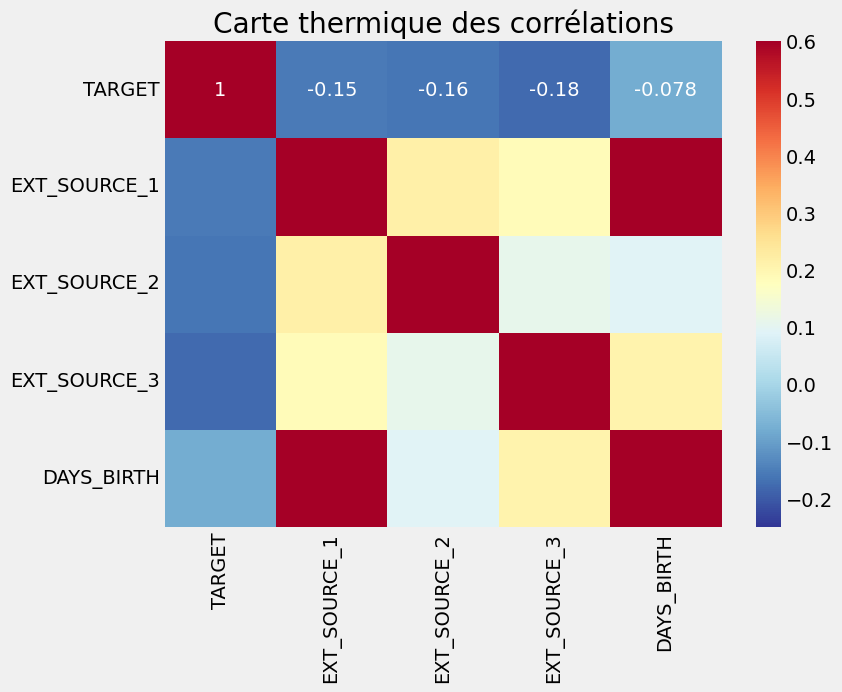

In [437]:
# Extraire les variables de source externe et montrer les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

plt.figure(figsize = (8, 6))

# Carte thermique des corrélations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Carte thermique des corrélations')

### Défaut de paiement

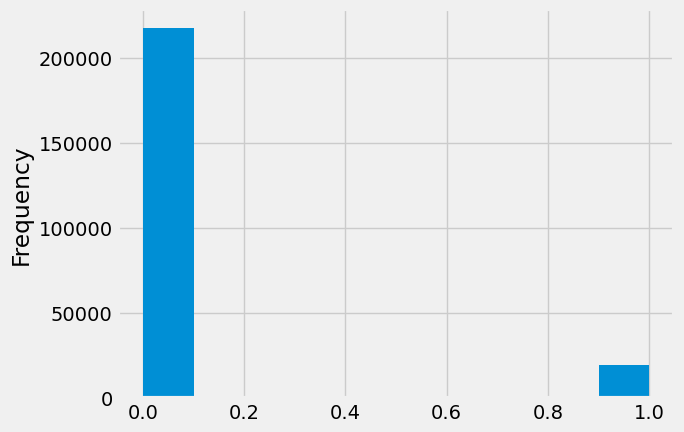

In [422]:
app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist();

Il est important de noter qu'il existe un déséquilibre significatif dans le jeu de données entre les individus qui remboursent leurs crédits de manière régulière et ceux qui sont en défaut de paiement. Ce déséquilibre peut avoir un impact sur les modèles de prédiction et entraîner des biais dans les résultats des modèles et affecter leur capacité à prédire correctement les cas de défaut de paiement.

### Anomalies Emploi

Il y a 12832 anomalies dans les données de test sur 71013 entrées


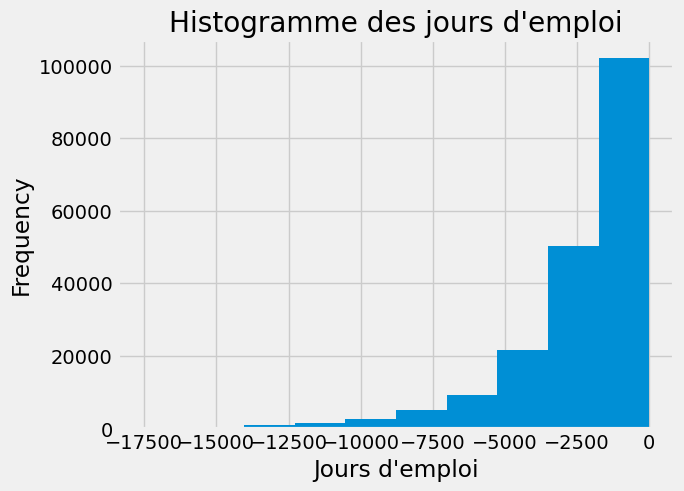

In [430]:
# Créer une colonne de drapeau pour les valeurs anormales
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Afficher un histogramme des jours d'emploi
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours d\'emploi');
plt.xlabel('Jours d\'emploi');

# Créer une colonne de drapeau pour les valeurs anormales dans app_test
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par NaN dans app_test
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# Imprimer le nombre d'anomalies dans les données de test
print('Il y a %d anomalies dans les données de test sur %d entrées' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))


In [432]:
# Trouver la corrélation entre les jours positifs depuis la naissance et la cible
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07789909207189787

### Ages des clients

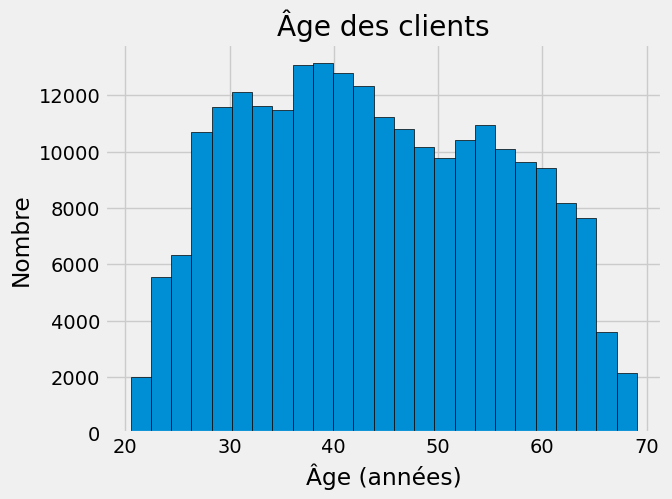

In [433]:
# Définir le style des graphiques
plt.style.use('fivethirtyeight')

# Tracer la distribution des âges en années
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Âge des clients'); plt.xlabel('Âge (années)'); plt.ylabel('Nombre');

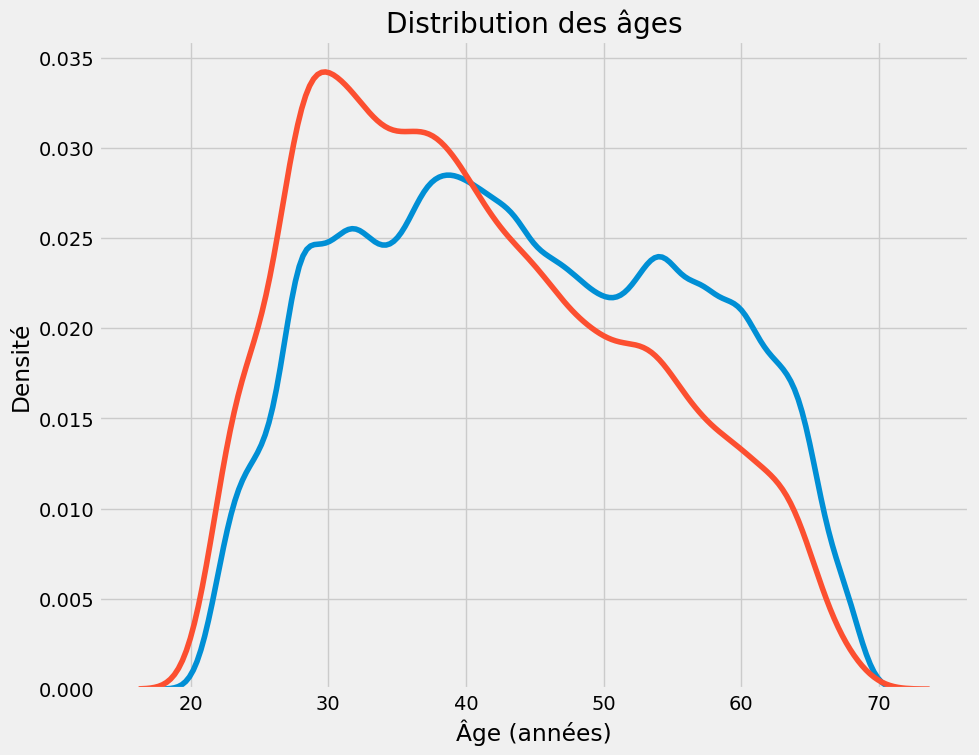

In [434]:
plt.figure(figsize = (10, 8))

# Graphique KDE des prêts remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# Graphique KDE des prêts non remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Étiquetage du graphique
plt.xlabel('Âge (années)'); plt.ylabel('Densité'); plt.title('Distribution des âges');


In [435]:
# Informations sur l'âge dans un DataFrame séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Regrouper les données d'âge en tranches
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


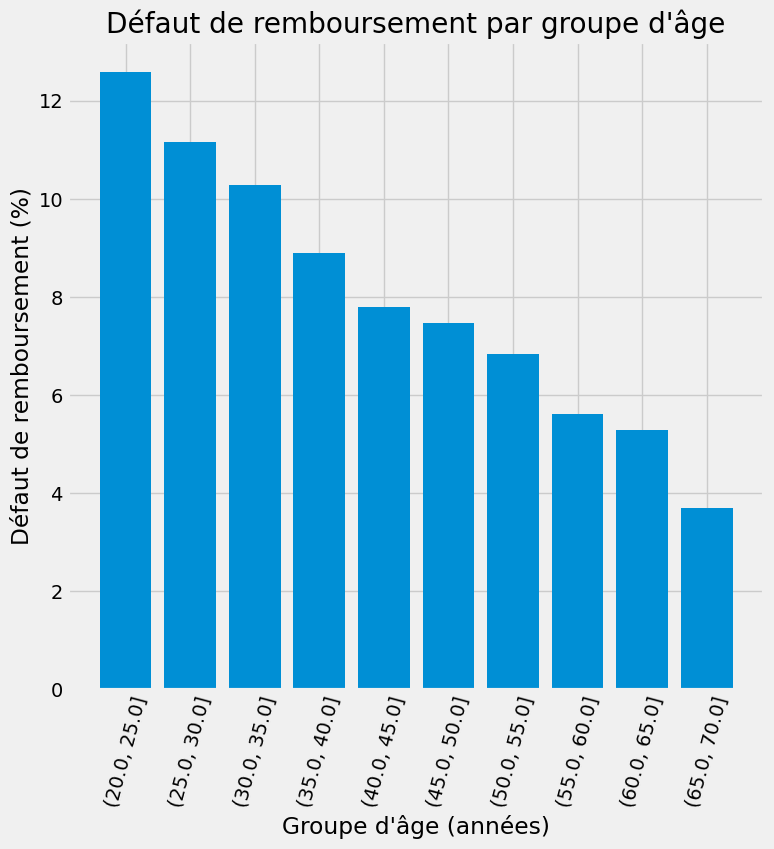

In [436]:
# Grouper par tranche d'âge et calculer les moyennes
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

plt.figure(figsize = (8, 8))

# Tracer les tranches d'âge et la moyenne de la cible comme un graphique en barres
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Étiquetage du graphique
plt.xticks(rotation = 75); plt.xlabel('Groupe d\'âge (années)'); plt.ylabel('Défaut de remboursement (%)')
plt.title('Défaut de remboursement par groupe d\'âge');


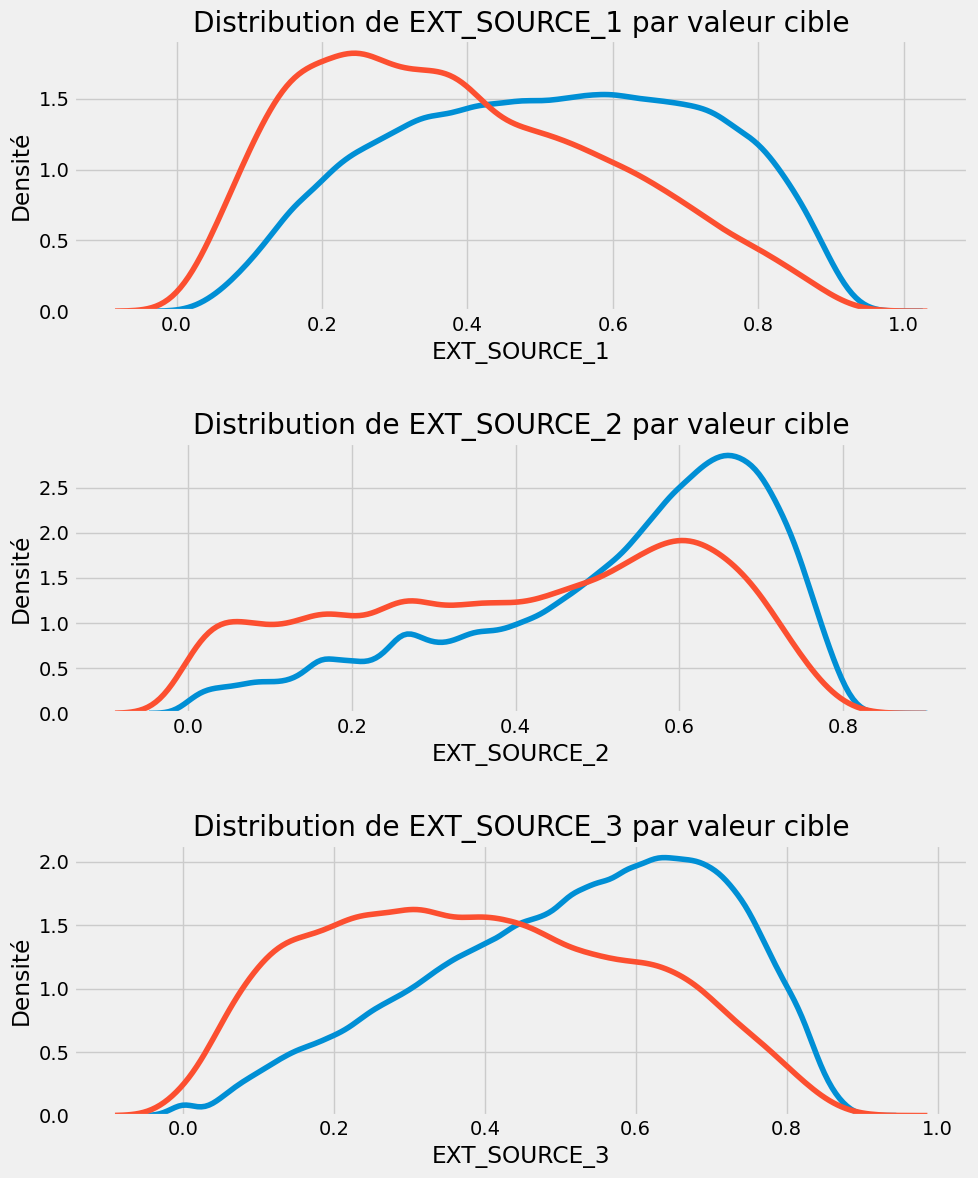

In [438]:
plt.figure(figsize = (10, 12))

# Itérer à travers les sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Créer un nouveau sous-graphique pour chaque source
    plt.subplot(3, 1, i + 1)
    # Tracer les prêts remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # Tracer les prêts non remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Étiqueter les graphiques
    plt.title('Distribution de %s par valeur cible' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)


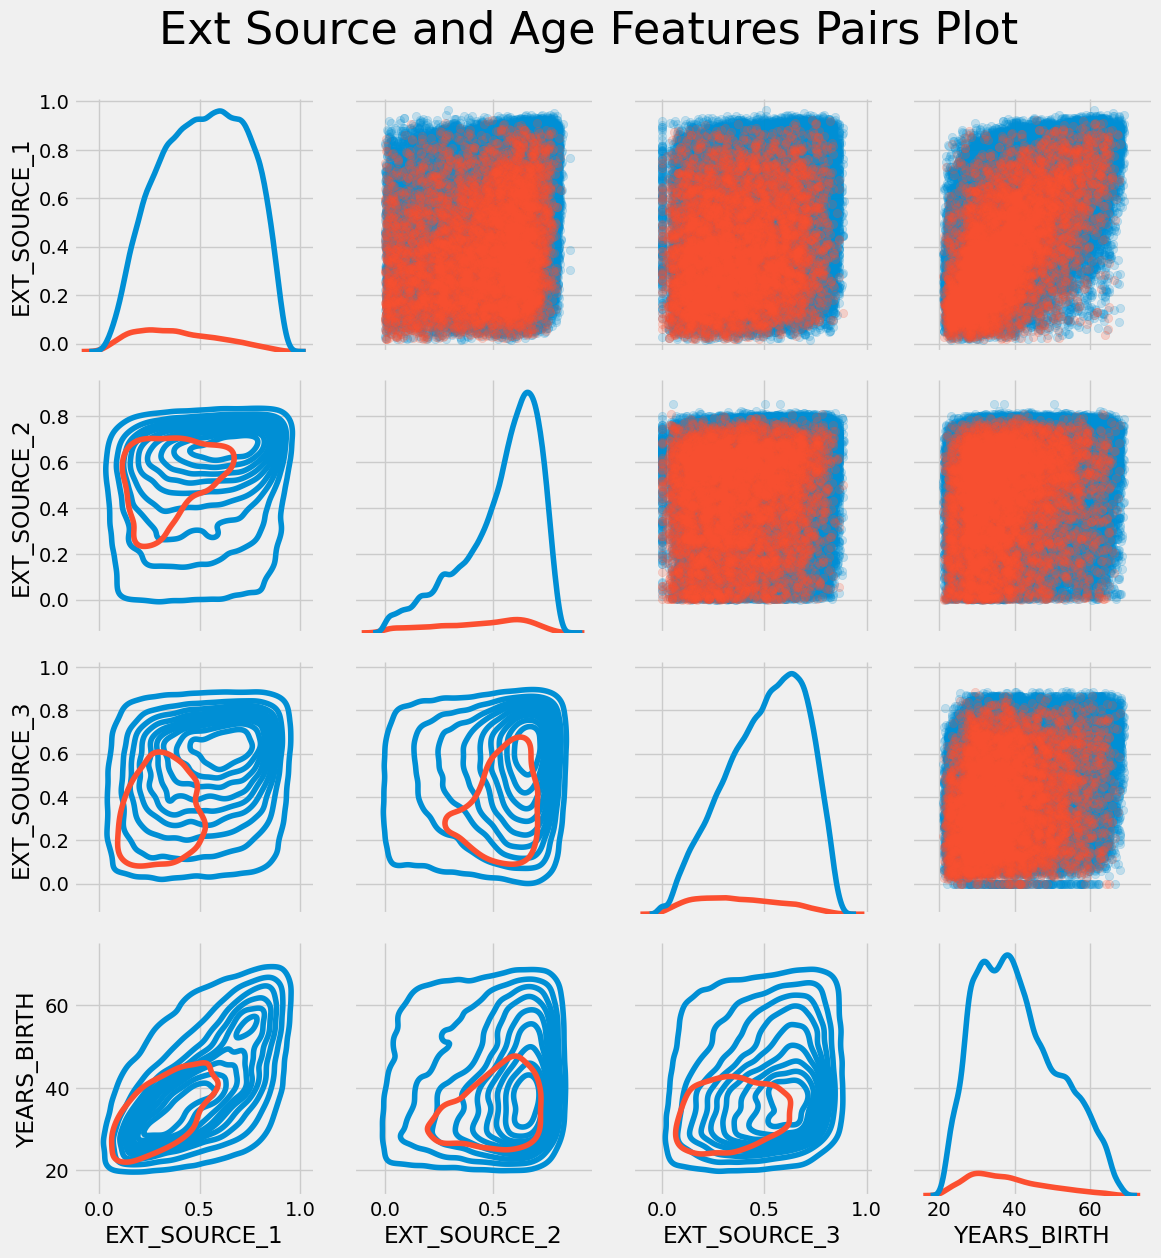

In [439]:
# Copier les données pour le tracé
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Ajouter l'âge du client en années
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Supprimer les valeurs manquantes et limiter aux 100000 premières lignes
plot_data = plot_data.dropna().iloc[:100000, :]

# Fonction pour calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size=20)

# Créer l'objet PairGrid
grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False, hue='TARGET',
                    vars=[x for x in plot_data.columns if x != 'TARGET'])

# Supérieur est un graphique de dispersion
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonale est un histogramme
grid.map_diag(sns.kdeplot)

# Inférieur est un graphique de densité
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

# Ajouter un titre
plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

# Afficher le graphique
plt.show()

In [440]:
train_data.to_csv('data/application_train_split.csv', index=False)
test_data.to_csv('data/application_test_split.csv', index=False)